# Клепиков Никита
Вариант 7

Группа 6132

In [126]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
from sklearn.metrics.cluster import contingency_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean

In [127]:
def plot_colored_points(X, colors):
    fig = plt.figure()
    fig.set_size_inches(14, 7)
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    axes.scatter(X[:,0], X[:,1], c=colors)

def plot_cost(cost):
    fig = plt.figure()
    fig.set_size_inches(14, 7)
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    axes.plot(cost)

In [128]:
specter = np.load('7.npy')
mask = np.load('7_mask.npy')
specter.shape, mask.shape

((512, 512, 237), (512, 512))

In [129]:
depth = specter.shape[2]
specter = specter.reshape(-1,depth)
mask = mask.reshape(-1)
specter.shape, mask.shape

((262144, 237), (262144,))

In [131]:
def metrics_purity(class_labels, cluster_labels):
    c_m = contingency_matrix(class_labels, cluster_labels)
    return np.sum(np.amax(c_m, axis=0)) / np.sum(c_m) 

In [132]:
def euclidean(x, y):
    diff = x - y
    dist_2 = np.sum(diff * diff, axis=-1)
    return np.sqrt(dist_2)

In [133]:
def metrics_davies_bouldin(X, cluster_labels, distance=euclidean):
    n_cluster = len(np.bincount(cluster_labels))
    cluster_k = [X[cluster_labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    variances = [np.mean([distance(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    db = []

    for i in range(n_cluster):
        for j in range(n_cluster):
            if j != i:
                db.append((variances[i] + variances[j]) / distance(centroids[i], centroids[j]))

    return(np.max(db) / n_cluster)

In [134]:
def manhattan(x, y):
    diff = np.abs(x - y)
    return np.sum(diff, axis=-1)

In [135]:
def chebyshev(x,y):
    diff = np.abs(x - y)
    return np.max(diff, axis=-1)

In [145]:
def k_means(X, K, distance=euclidean, max_iter=20):
    N, D = X.shape
    L = np.zeros(N)
    M = np.zeros((K, D))

    for k in range(K):
        M[k] = X[np.random.choice(N)]
    
    M_prev = M.copy()
    for i in range(max_iter):
        dists = []

        for k in range(K):
            dists += [distance(X, M[k]).reshape(-1, 1)]
        dists = np.hstack(dists) 
        L = np.argmin(dists, axis=1)

        for k in range(K):
            M[k] = X[L==k].mean(axis=0)
            
        if np.allclose(M, M_prev):
            print(f'KMeans converged on {i}th iteration')
            break
        else:
            M_prev = M.copy()
    plot_cost(losses)
    colors = np.random.random((K,3))
    p_colors = R.dot(colors)
    plot_colored_points(X, p_colors)
    return M, L

KMeans converged on 8th iteration
Converged: 0.322339438609581
1 iteration: 0.4640622998048327
2 iteration: 0.3335419150745657
3 iteration: 0.34993993528891015


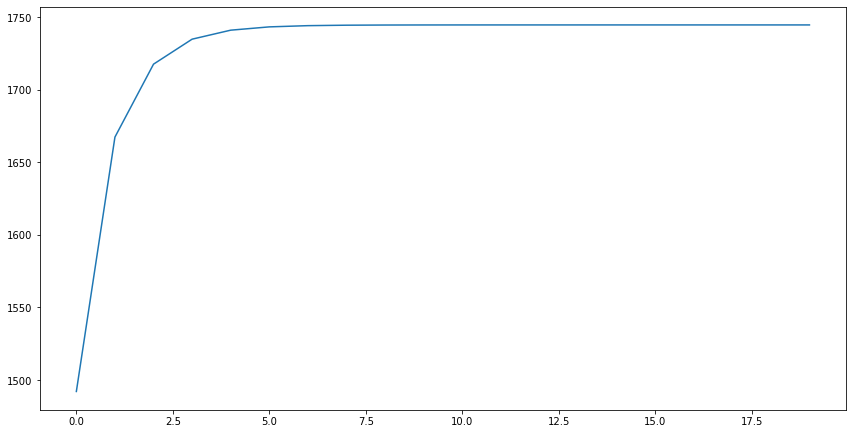

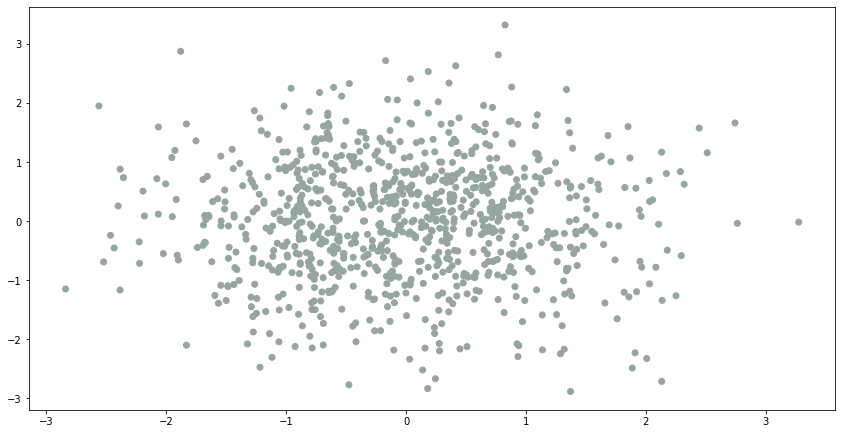

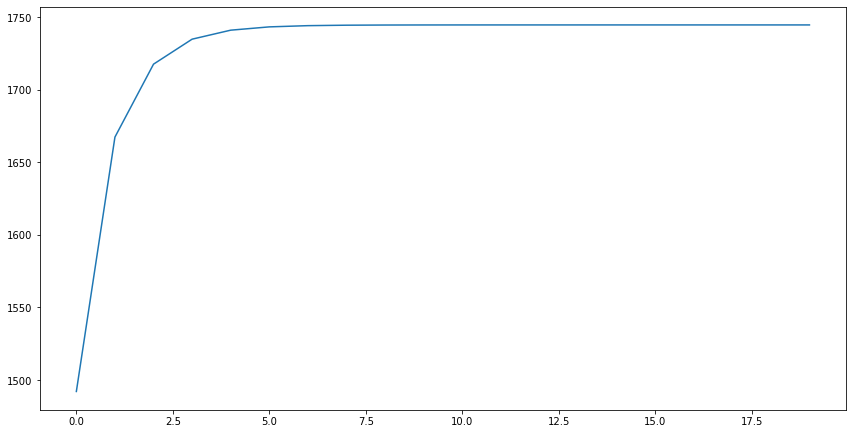

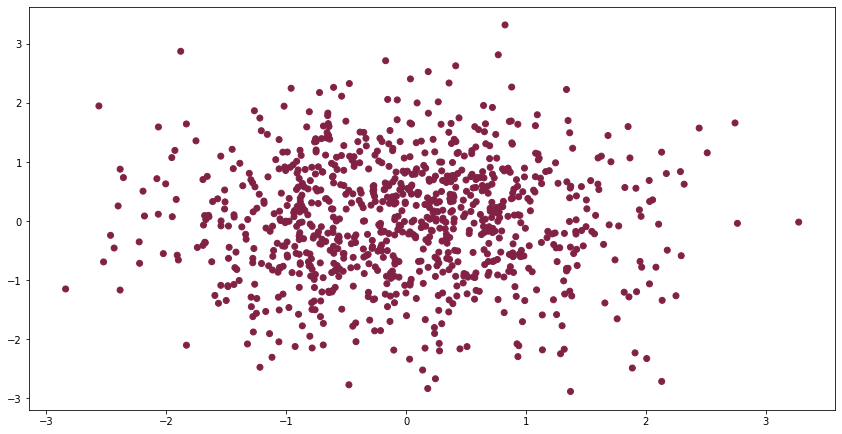

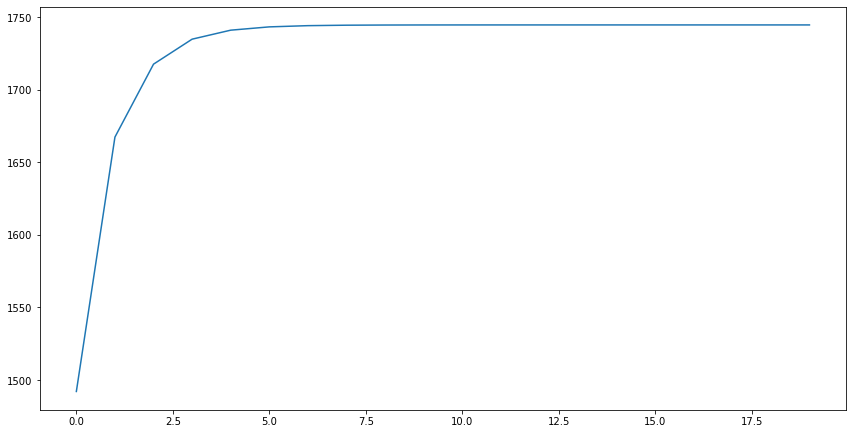

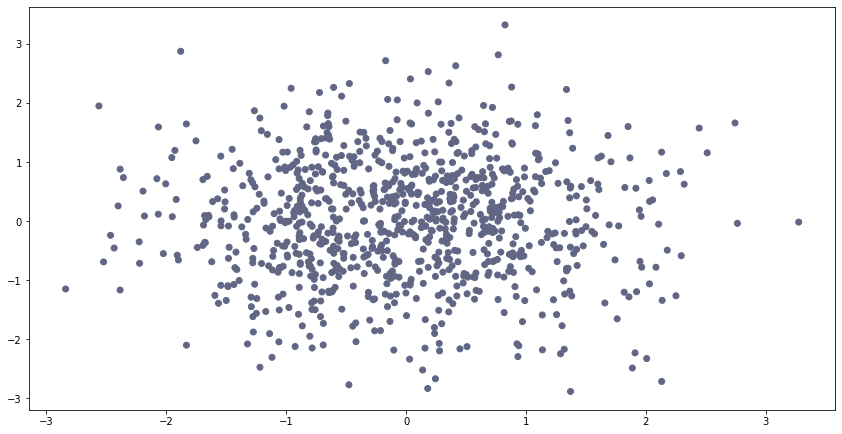

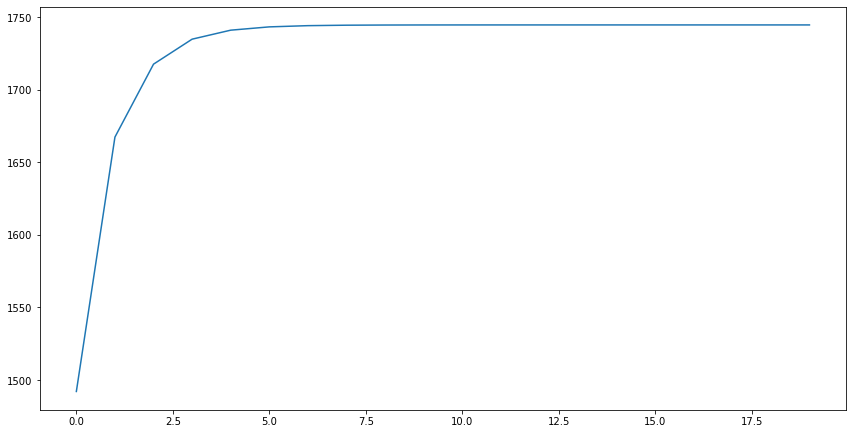

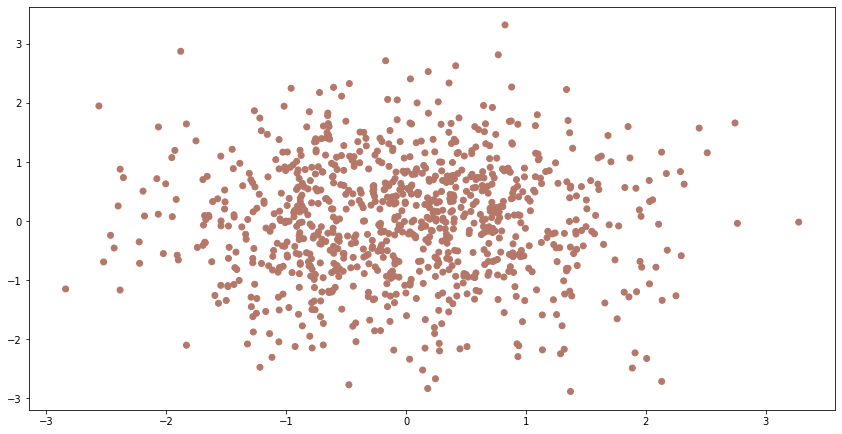

In [146]:
M, L = k_means(X, K=3)
print(f'Converged: {metrics_davies_bouldin(X, L)}')
M, L = k_means(X, K=3, max_iter=1)
print(f'1 iteration: {metrics_davies_bouldin(X, L)}')
M, L = k_means(X, K=3, max_iter=2)
print(f'2 iteration: {metrics_davies_bouldin(X, L)}')
M, L = k_means(X, K=3, max_iter=3)
print(f'3 iteration: {metrics_davies_bouldin(X, L)}')

In [138]:
def cluster_resp(distances):
    d_exp = np.exp(-distances)
    return d_exp / np.sum(d_exp, axis=1, keepdims=True)

In [139]:
def loss(X, M, R, distance=euclidean):
    loss = 0
    for k in range(len(M)):
        d = distance(X, M[k])
        loss += np.sum(R[:,k] * (d * d))
    return loss

In [140]:
def soft_k_means(X, K, distance=euclidean, max_iter=20):
    N, D = X.shape
    R = np.zeros((N, K))
    M = np.zeros((K, D))
    losses = []
    for k in range(K):
        M[k] = X[np.random.choice(N)]
    for i in range(max_iter):
        dists = []
        for k in range(K):
            dists += [distance(X, M[k]).reshape(-1, 1)]
        dists = np.hstack(dists) # (K, N, 1) -> (N, K)
        R = cluster_resp(dists)
        for k in range(K):
            M[k] = R[:,k].dot(X) / R[:,k].sum()
        losses.append(loss(X, M, R, distance))
        if len(losses) > 2 and np.abs(losses[-1] - losses[-2]) < 1e-6:
            print(f'KMeans converged on {i}th iteration')
            break
    plot_cost(losses)
    colors = np.random.random((K,3))
    p_colors = R.dot(colors)
    plot_colored_points(X, p_colors)
    return M, R, losses

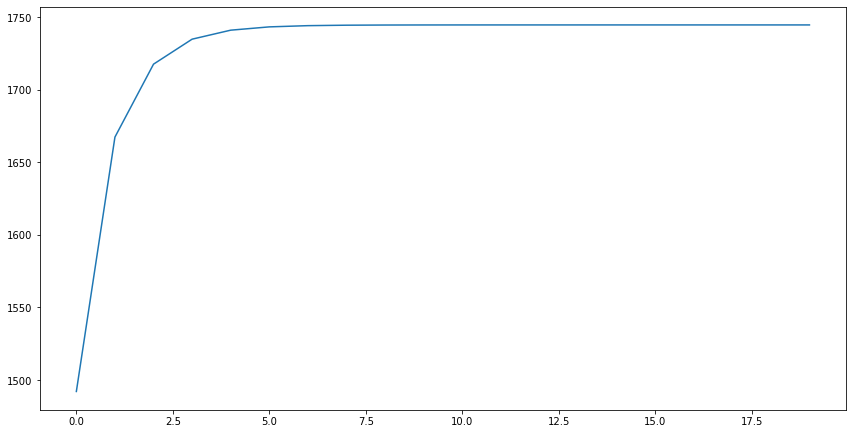

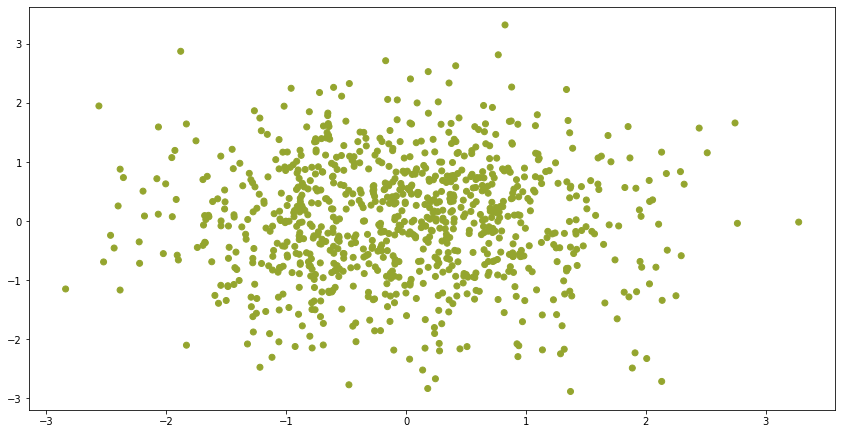

In [141]:
M, R, losses = soft_k_means(X, K=3, max_iter=20)

In [60]:
results = pd.DataFrame(columns=['K', 'performance_metric', 'distance_metric', 'clustering_method', 'score'])
best_purity = 0
best_L = np.array([])

for K in range(2, 11, 2):  

  # 1 k_means

  # 1.1 euclidean

    M, L = k_means(specter, K, euclidean)

    purity = metrics_purity(mask, L)
    if purity > best_purity:
        best_purity = purity 
        best_L = L
    results = results.append({
      'K': K,
      'performance_metric': 'purity',
      'distance_metric': 'euclidean',
      'clustering_method': 'k_means',
      'score': purity
      }, ignore_index=True)
  
    results = results.append({
      'K': K,
      'performance_metric': 'davies_bouldin',
      'distance_metric': 'euclidean',
      'clustering_method': 'k_means',
      'score': metrics_davies_bouldin(specter, L, euclidean)
      }, ignore_index=True)

  # 1.2 manhattan
  
    M, L = k_means(specter, K, manhattan)
  
    purity = metrics_purity(mask, L)
    if purity > best_purity:
        best_purity = purity 
        best_L = L
    results = results.append({
      'K': K,
      'performance_metric': 'purity',
      'distance_metric': 'manhattan',
      'clustering_method': 'k_means',
      'score': purity
      }, ignore_index=True)
  
    results = results.append({
      'K': K,
      'performance_metric': 'davies_bouldin',
      'distance_metric': 'manhattan',
      'clustering_method': 'k_means',
      'score': metrics_davies_bouldin(specter, L, manhattan)
      }, ignore_index=True)
  
  # 1.3 chebyshev

    M, L = k_means(specter, K, chebyshev)

    purity = metrics_purity(mask, L)
    if purity > best_purity:
        best_purity = purity 
        best_L = L
    results = results.append({
      'K': K,
      'performance_metric': 'purity',
      'distance_metric': 'chebyshev',
      'clustering_method': 'k_means',
      'score': purity
      }, ignore_index=True)
  
    results = results.append({
      'K': K,
      'performance_metric': 'davies_bouldin',
      'distance_metric': 'chebyshev',
      'clustering_method': 'k_means',
      'score': metrics_davies_bouldin(specter, L, chebyshev)
      }, ignore_index=True)
  
  # 2 soft_k_means

  # 2.1 euclidean

    M, R, losses = soft_k_means(specter, K, euclidean)
    L = np.argmax(R, axis=1)

    purity = metrics_purity(mask, L)
    if purity > best_purity:
        best_purity = purity 
        best_L = L
    results = results.append({
      'K': K,
      'performance_metric': 'purity',
      'distance_metric': 'euclidean',
      'clustering_method': 'soft_k_means',
      'score':purity
      }, ignore_index=True)
  
    results = results.append({
      'K': K,
      'performance_metric': 'davies_bouldin',
      'distance_metric': 'euclidean',
      'clustering_method': 'soft_k_means',
      'score': metrics_davies_bouldin(specter, L, euclidean)
      }, ignore_index=True)
  
  # 2.2 manhattan
  
    M, R, losses = soft_k_means(specter, K, manhattan)
    L = np.argmax(R, axis=1)

    purity = metrics_purity(mask, L)
    if purity > best_purity:
        best_purity = purity 
        best_L = L
    results = results.append({
      'K': K,
      'performance_metric': 'purity',
      'distance_metric': 'manhattan',
      'clustering_method': 'soft_k_means',
      'score': purity
      }, ignore_index=True)
  
    results = results.append({
      'K': K,
      'performance_metric': 'davies_bouldin',
      'distance_metric': 'manhattan',
      'clustering_method': 'soft_k_means',
      'score': metrics_davies_bouldin(specter, L, manhattan)
      }, ignore_index=True)
  
  # 2.3 chebyshev

    M, R, losses = soft_k_means(specter, K, chebyshev)
    L = np.argmax(R, axis=1)

    purity = metrics_purity(mask, L)
    if purity > best_purity:
        best_purity = purity 
        best_L = L
    results = results.append({
      'K': K,
      'performance_metric': 'purity',
      'distance_metric': 'chebyshev',
      'clustering_method': 'soft_k_means',
      'score': purity
      }, ignore_index=True)
  
    results = results.append({
      'K': K,
      'performance_metric': 'davies_bouldin',
      'distance_metric': 'chebyshev',
      'clustering_method': 'soft_k_means',
      'score': metrics_davies_bouldin(specter, L, chebyshev)
      }, ignore_index=True)

KMeans converged on 7th iteration
KMeans converged on 6th iteration


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
D:\anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KMeans converged on 6th iteration
KMeans converged on 7th iteration
KMeans converged on 7th iteration


## 1. DataFrame с чистотой и DBI для каждой метрики расстояния для наилучшего параметра K

In [61]:
best_k_results = pd.DataFrame

for clustering_method, clustering_method_group in results.groupby('clustering_method'):
    best_k_in_clustering_method_group = pd.DataFrame(columns=['davies_bouldin', 'purity'], index=['chebyshev', 'euclidean', 'manhattan'])

    for performance_metric, performance_metric_group in clustering_method_group.groupby('performance_metric'):
        distance_metric_list = []

        for distance_metric, distance_metric_group in performance_metric_group.groupby('distance_metric'):
            best_K = results.iloc[distance_metric_group['score'].idxmax()]['K']
            best_score = distance_metric_group['score'].max()
            best_k_in_clustering_method_group.loc[distance_metric, performance_metric] = best_score
      
    print(clustering_method)
    print(best_k_in_clustering_method_group)
    print()

k_means
          davies_bouldin    purity
chebyshev       0.482376  0.694096
euclidean        0.47837  0.703125
manhattan       0.455023   0.70129

soft_k_means
          davies_bouldin    purity
chebyshev       0.536421  0.520546
euclidean       2.498085   0.55899
manhattan       0.455343  0.705166



## 2. График, показывающий результат оценки зависимости между чистотой и K, DBI и K

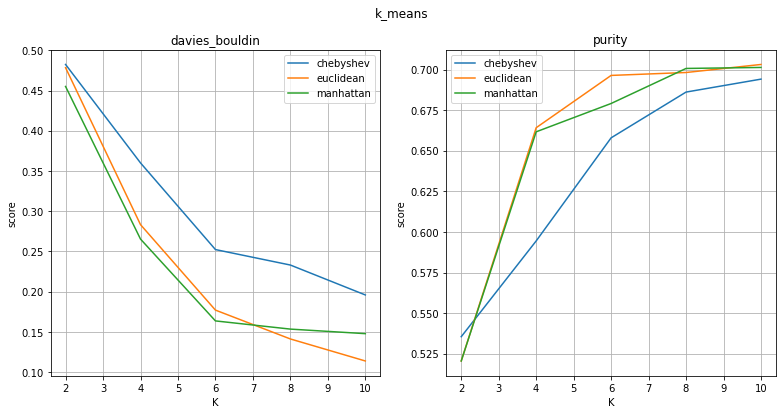

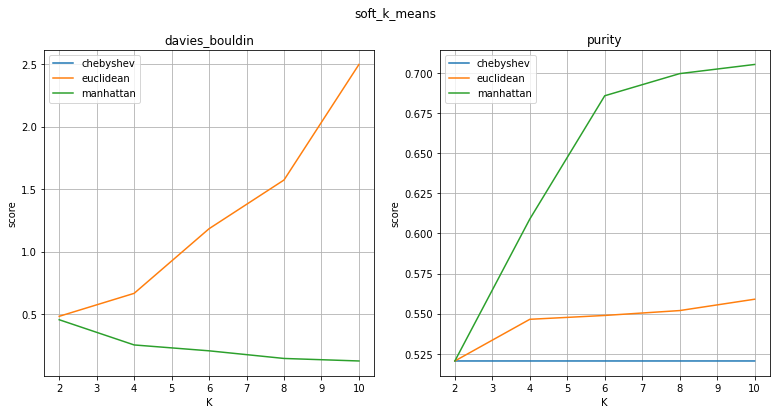

In [68]:
for clustering_method, clustering_method_group in results.groupby('clustering_method'):
    plt.figure(figsize=(13,6))
    i = 1

    for performance_metric, performance_metric_group in clustering_method_group.groupby('performance_metric'):

        plt.subplot(1, 2, i)
        plt.title(performance_metric)

        for distance_metric, distance_metric_group in performance_metric_group.groupby('distance_metric'):
            plt.plot(distance_metric_group['K'], distance_metric_group['score'], label=distance_metric)
    
        plt.legend()
        plt.grid()
        i += 1
        plt.xlabel('K')
        plt.ylabel('score')
  
    plt.suptitle(clustering_method)
    plt.show()

# 3. Визуализация пресказаний лучшей модели

Text(0.5, 1.0, 'predictions')

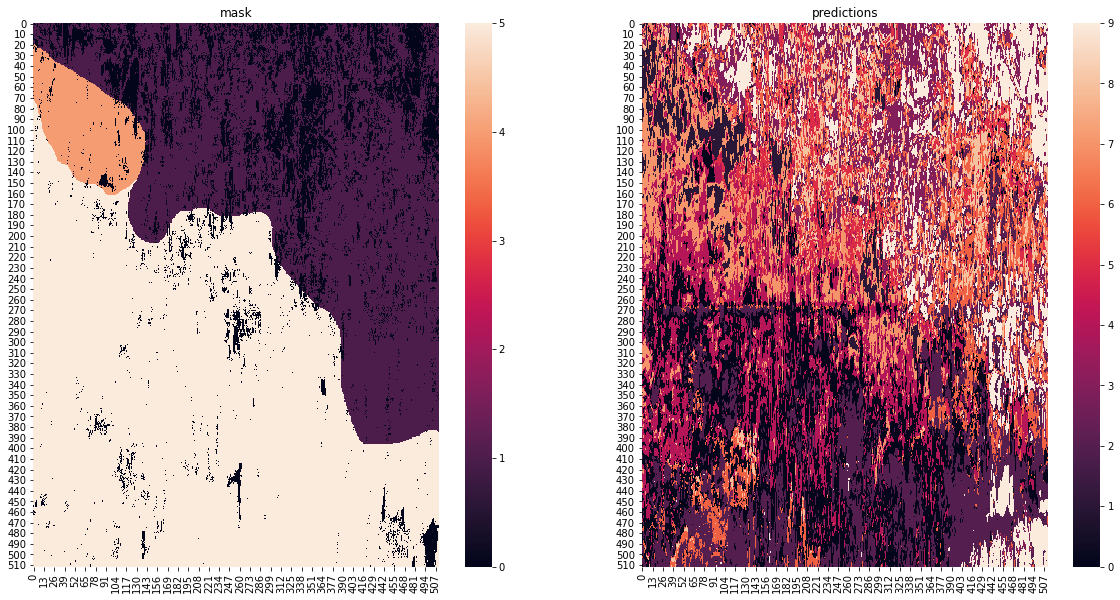

In [69]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
sns.heatmap(mask.base, ax=ax1)
sns.heatmap(best_L.reshape((512,512)), ax=ax2)
ax1.set_title('mask')
ax2.set_title('predictions')